# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import missingno as msno

# Datos

In [134]:
ruta = 'df_solares.xlsx'
df = pd.read_excel(ruta, engine='openpyxl')

In [135]:
df.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

In [136]:
ruta = 'df_eolicos.xlsx'
dfe = pd.read_excel(ruta, engine='openpyxl')
del ruta

## Valores perdidos

In [137]:
df.dtypes

Real                         float64
Nombre                        object
Fecha                 datetime64[ns]
Externo                      float64
Coordinado                   float64
SExperto                     float64
Vertimiento                  float64
Potencia_max_bruta           float64
dtype: object

In [138]:
df.isnull().sum()

Real                      62
Nombre                     0
Fecha                      0
Externo                78542
Coordinado             93182
SExperto              106004
Vertimiento           223622
Potencia_max_bruta         0
dtype: int64

<Axes: >

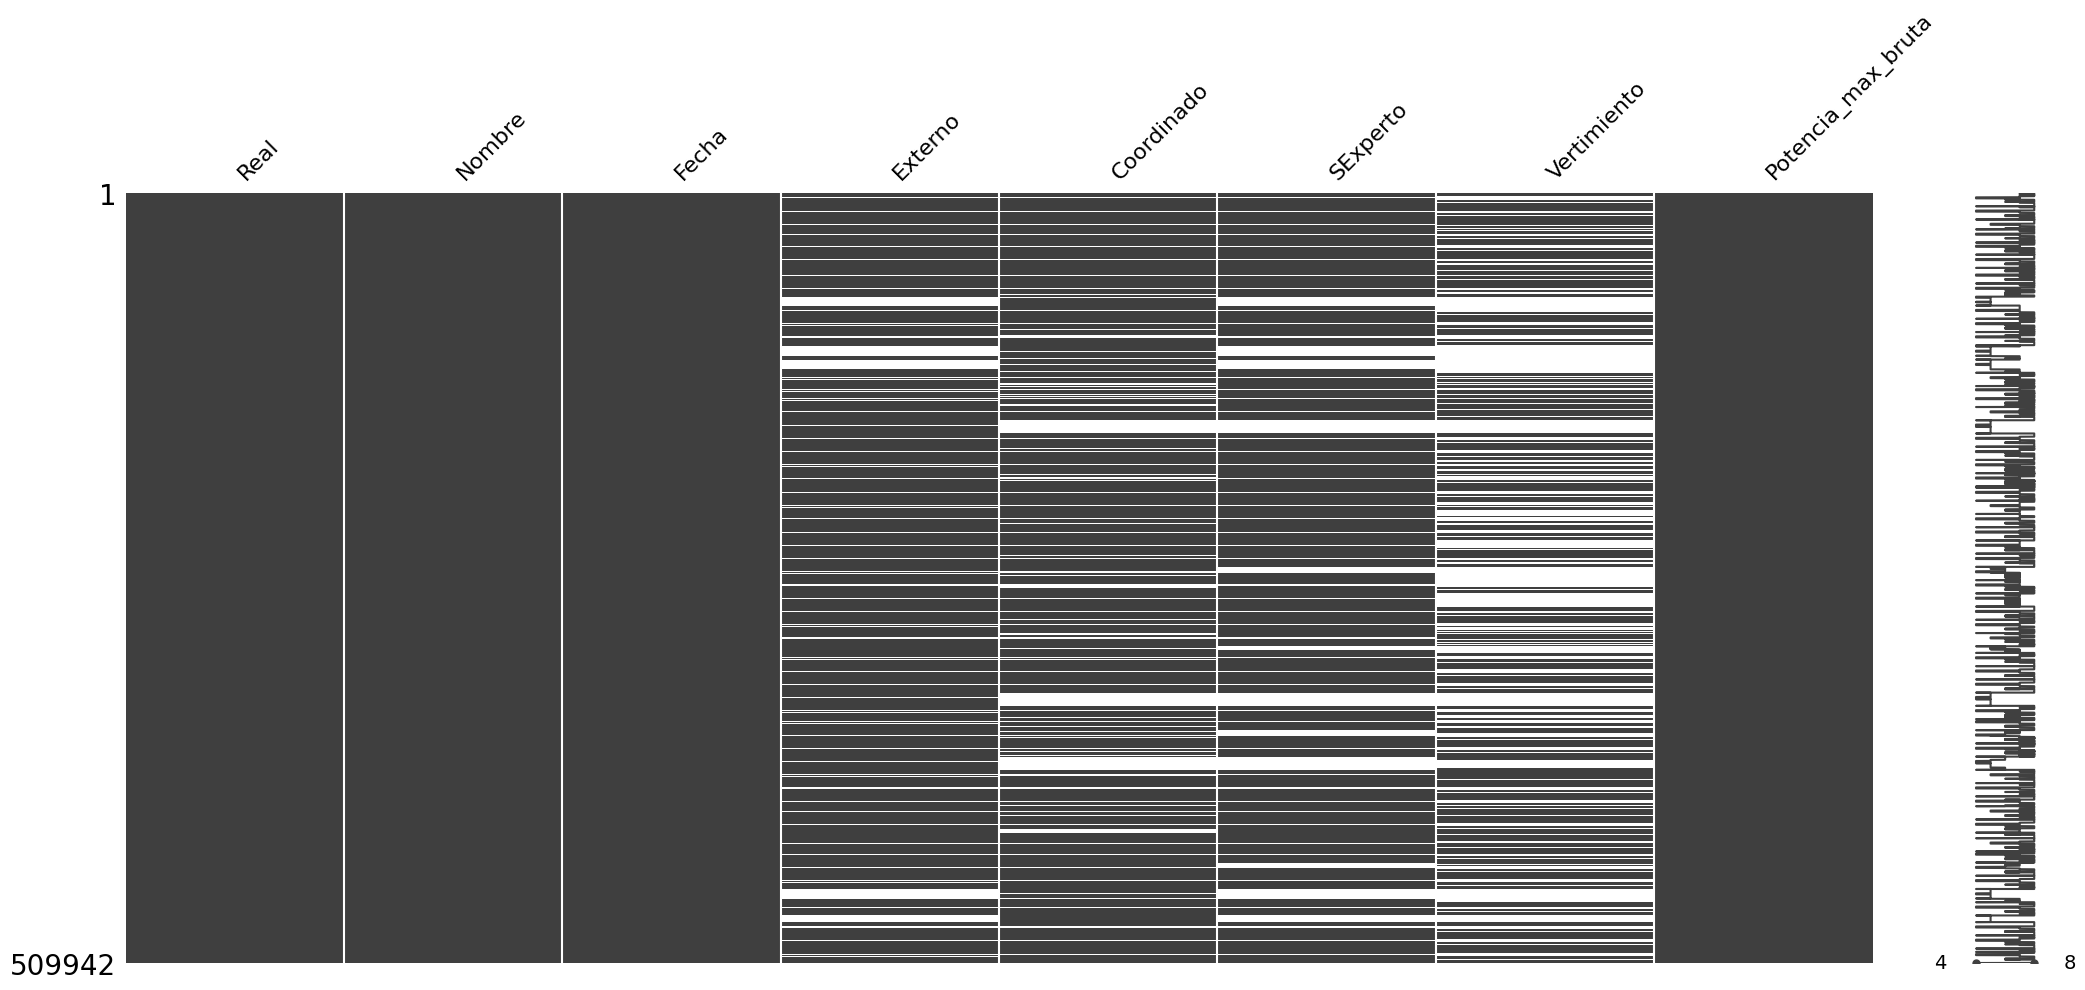

In [139]:
df.sort_values(by='Fecha')
msno.matrix(df)

In [140]:
# Calcular el coeficiente de asimetría
pronosticos = ['Real', 'Externo', 'Coordinado', 'SExperto']
print(pronosticos)
for i in pronosticos:

  skewness = df[i].skew()
  print(f"Coeficiente de Asimetría: {skewness}")

  # Interpretación del resultado
  if skewness > 0:
      print(f"La distribución de {i} tiene un sesgo positivo (hacia la derecha).")
  elif skewness < 0:
      print(f"La distribución de {i} tiene un sesgo negativo (hacia la izquierda).")
  else:
      print(f"La distribución de {i} es aproximadamente simétrica.")
del skewness, pronosticos, i

['Real', 'Externo', 'Coordinado', 'SExperto']
Coeficiente de Asimetría: 2.687846633062125
La distribución de Real tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.4600070215871415
La distribución de Externo tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.378657226430205
La distribución de Coordinado tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.26252988146878
La distribución de SExperto tiene un sesgo positivo (hacia la derecha).


In [141]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))

Vertimiento           43.852438
SExperto              20.787462
Coordinado            18.273059
Externo               15.402144
Real                   0.012158
Nombre                 0.000000
Fecha                  0.000000
Potencia_max_bruta     0.000000
dtype: float64


In [142]:
# Conteo de filas con valores faltantes
filas_con_faltantes = df.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor faltante: {filas_con_faltantes}")
del filas_con_faltantes

Número de filas con al menos un valor faltante: 257897


In [143]:
df = df.sort_values('Fecha')
df_imputado = df.interpolate()

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\3836364637.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_imputado = df.interpolate()


In [144]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado .isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Real                  0.009805
Nombre                0.000000
Fecha                 0.000000
Externo               0.000000
Coordinado            0.000000
SExperto              0.000000
Vertimiento           0.000000
Potencia_max_bruta    0.000000
dtype: float64


In [145]:
mask = df_imputado.isna().any(axis=1)

# Filtrar el DataFrame para mostrar solo esas filas
df_con_valores_vacios = df_imputado[mask]

print(df_con_valores_vacios['Fecha'].dt.hour.unique())
del df_con_valores_vacios,  mask

[0]


In [146]:
df_imputado = df_imputado.fillna(0)

In [147]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Real                  0.0
Nombre                0.0
Fecha                 0.0
Externo               0.0
Coordinado            0.0
SExperto              0.0
Vertimiento           0.0
Potencia_max_bruta    0.0
dtype: float64


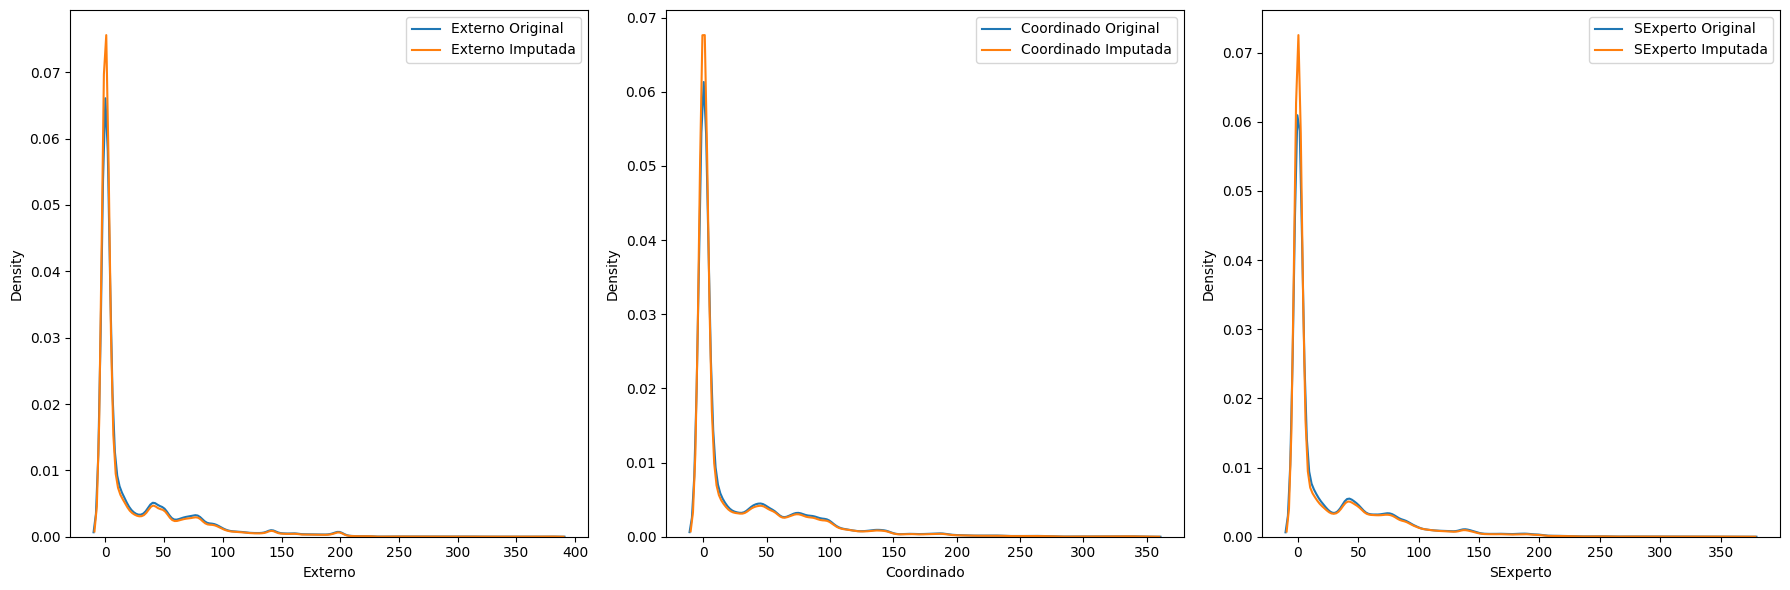

In [148]:
columnas = ['Externo', 'Coordinado', 'SExperto']

plt.figure(figsize=(18, 6))
for i, columna in enumerate(columnas, 1):
    plt.subplot(1, len(columnas), i)
    sn.kdeplot(df[f'{columna}'].dropna(), label=f'{columna} Original')
    sn.kdeplot(df_imputado[f'{columna}'], label=f'{columna} Imputada')
    plt.legend()
plt.tight_layout()
plt.show()
del columnas, i

## Transformación: Generación potencial

In [251]:
df_edit = df_imputado.copy()

In [252]:
# Sumar las columnas 'Real' y 'Vertimiento' para obtener la generación potencial
df_edit['Generacion_Potencial'] = df_edit['Real'].fillna(0) + df_edit['Vertimiento'].fillna(0)
df_edit.drop(columns={'Real','Vertimiento'}, inplace=True)


In [253]:
df_edit

,Nombre,Fecha,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial
0,PFV ALMEYDA,2023-01-01,0.0,0.0,0.0,56.8000,0.0
168019,PFV EL ROMERO,2023-01-01,0.0,0.0,0.0,196.0000,0.0
265135,PFV LALACKAMA II,2023-01-01,0.0,0.0,0.0,16.5000,0.0
176780,PFV FINIS TERRAE,2023-01-01,0.0,0.0,0.0,248.2100,0.0
40853,PFV BOLERO,2023-01-01,0.0,0.0,0.0,138.2000,0.0
...,...,...,...,...,...,...,...
460926,PFV SOL DEL DESIERTO,2024-01-01,0.0,0.0,0.0,230.4800,0.0
230090,PFV LA CRUZ SOLAR,2024-01-01,0.0,0.0,0.0,52.8137,0.0
221329,PFV JAVIERA,2024-01-01,0.0,0.0,0.0,69.0180,0.0
212568,PFV JAMA,2024-01-01,0.0,0.0,0.0,52.6500,0.0


## Limpieza: filtración de horas sin actividad solar

In [258]:
df_edit.set_index('Fecha', inplace=True)
df_edit['Hora'] = df_edit.index.hour
df_edit.reset_index(inplace=True)

In [259]:
df_maxima_generacion = df_edit.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
# Luego, necesitas obtener los valores únicos de 'Potencia_max_bruta' por 'Nombre'
potencia_maxima = df_edit.groupby('Nombre')['Potencia_max_bruta'].max().reset_index()

# Finalmente, haces un merge para agregar 'Potencia_max_bruta' a tu df_maxima_generacion
df_maxima_generacion = df_maxima_generacion.merge(potencia_maxima, on='Nombre', how='left')
df_maxima_generacion['pot1'] =df_maxima_generacion['Potencia_max_bruta']*0.015

In [260]:
# Agrupamos por 'Nombre' y 'Hora', y luego obtenemos el máximo de 'Generacion_Potencial' para cada grupo
#df_maxima_generacion = df_edit.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
#dataframe con las horas por central que tienen maxima generación igual 0
maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] <= df_maxima_generacion['pot1'] ]
#Eliminamos columna para no obtener una duplicada en el merge
maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
#Hacemos un df con las filas que queremos eliminar
dfEliminar = pd.merge(df_edit, maxGenCero, on=['Nombre', 'Hora'], how='inner')

# Asumiendo que df_eliminar contiene las filas a eliminar basadas en 'Nombre' y 'Hora'
# Creamos un identificador único combinando 'Nombre' y 'Hora' para ambas DataFrames
df_edit['identificador'] = df_edit['Nombre'] + df_edit['Fecha'].astype(str)
dfEliminar['identificador'] = dfEliminar['Nombre'] + dfEliminar['Fecha'].astype(str)

# Filtramos df_solares para excluir las filas cuyos identificadores están en df_eliminar
identificadores_para_eliminar = set(dfEliminar['identificador'])
df_limpio = df_edit[~df_edit['identificador'].isin(identificadores_para_eliminar)]

# Opcional: Puedes eliminar la columna 'identificador' si ya no la necesitas
df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)
del df_maxima_generacion, maxGenCero, identificadores_para_eliminar, dfEliminar, df_edit

# Ahora df_solares_limpio contiene solo las filas que no están en df_eliminar


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\2519146830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\2519146830.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)


## Variable hora (para dummies)

In [261]:
df_limpio['Hora'] = df_limpio['Fecha'].dt.hour

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\3325857352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['Hora'] = df_limpio['Fecha'].dt.hour


In [262]:
df_limpio['Hora'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Analisis exploratorio

In [263]:
central = 'PFV FINIS TERRAE'
datos_central = df_limpio[df_limpio['Nombre']== central]

In [257]:
 hor4= datos_central[datos_central['Hora'] == 21]

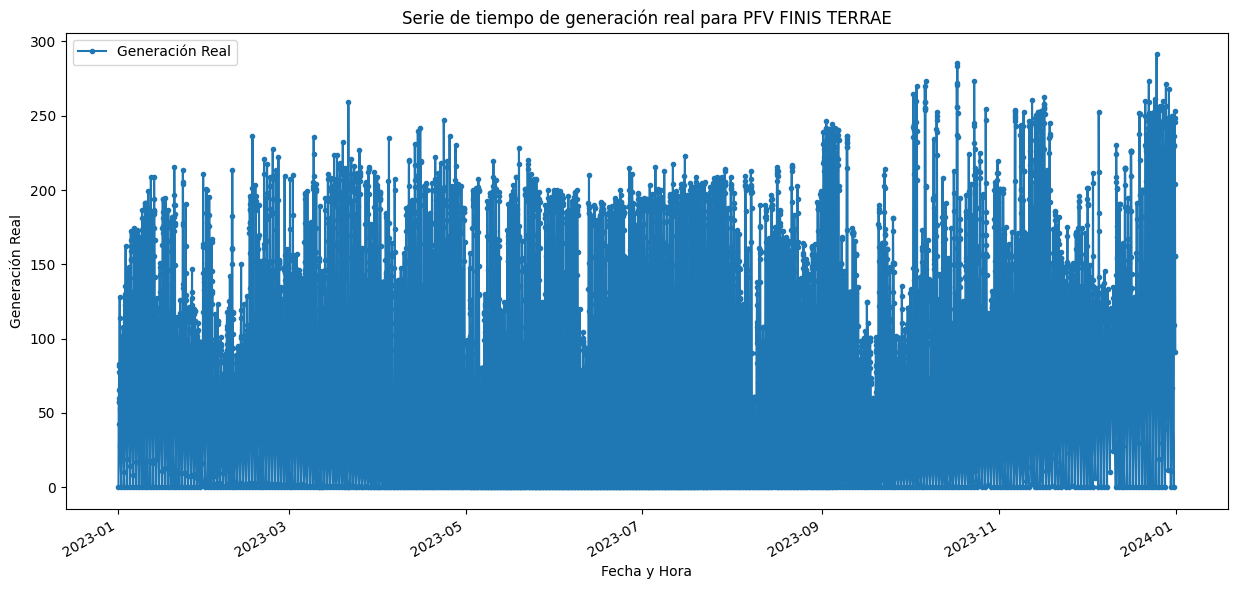

In [264]:
#Filtrar  datos por central
central = 'PFV FINIS TERRAE'
datos_central = df_limpio[df_limpio['Nombre']== central]

# Asegurarse de que los datos estén ordenados por fecha
datos_central = datos_central.sort_values(by='Fecha')

 # Crear un nuevo gráfico
plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación real
plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Real', marker='o', linestyle='-', markersize=3)

  # Añadir título y leyenda al gráfico
plt.title(f"Serie de tiempo de generación real para {central}")
plt.xlabel('Fecha y Hora')
plt.ylabel('Generación Real')
plt.legend()

# Mejorar el formato de la fecha en el eje x
plt.gcf().autofmt_xdate()

# Mostrar el gráfico
plt.show()




In [265]:
print(len(df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()))
df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()


14


array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Regresión

In [294]:
Y = datos_central['Generacion_Potencial']

In [295]:
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)

In [296]:
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)

In [298]:
X = sm.add_constant(X)

In [299]:
X

,const,Externo,Coordinado,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20
390,1.0,20.3,36.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,1.0,83.3,135.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472,1.0,105.4,212.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546,1.0,110.1,244.09,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,1.0,114.9,260.37,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509420,1.0,151.7,250.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
509463,1.0,152.3,241.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
509508,1.0,143.2,196.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
509630,1.0,68.3,86.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [231]:
"""var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]"""

"var_ind = ['Externo', 'Coordinado']\nfor var in var_ind:\n    for dummie in dummies.columns:\n        nombre_interaccion = f'{var}-{dummie}'\n        X[nombre_interaccion] = X[var] * X[dummie]"

In [232]:
"X"

'X'

# Sliding window

In [300]:
horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()
horas_relevantes

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [301]:

# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Multiplica por la cantidad de horas relevantes por día para obtener el punto de corte
punto_corte = num_dias_entrenamiento * len(horas_relevantes)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()


365


In [302]:

# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones
for dia in range(dias_totales - num_dias_entrenamiento):
    # Definir el conjunto de entrenamiento para la ventana actual
    inicio = dia * filas_por_dia
    fin = inicio + num_dias_entrenamiento * filas_por_dia
    X_train = X.iloc[inicio:fin]
    Y_train = Y.iloc[inicio:fin]

    # Ajustar el modelo
    modelo = sm.OLS(Y_train, X_train).fit()

    # Extraer y almacenar los parámetros estimados para la fecha actual
    parametros_actuales = modelo.params
    parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

    # Realizar predicciones para el siguiente día
    X_test = X.iloc[fin:fin + filas_por_dia]
    predicciones = modelo.predict(X_test)

    # Almacenar las predicciones
    predicciones_df = pd.concat([predicciones_df, predicciones])

    # Almacenar las variables utilizadas para la predicción del nuevo día
    variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
del X, X_train, X_test


        const   Externo  Coordinado        h_8         h_9        h_10  \
0    0.008874  0.008961   -0.004296 -29.609787 -100.637149  104.688089   
1    0.008969  0.008900   -0.004241 -25.162759  -51.561466   85.749163   
2    0.008971  0.008886   -0.004208 -21.373232   -4.712029   96.302015   
3    0.009202  0.008907   -0.004205 -18.037902   29.834897  119.307322   
4    0.009190  0.008855   -0.004153 -15.997417   40.610483  128.834275   
..        ...       ...         ...        ...         ...         ...   
240 -0.048550  0.032501   -0.005513 -39.138686   54.717751  151.172669   
241 -0.052593  0.031889   -0.005137 -37.651377   51.579707  148.526185   
242 -0.057342  0.031304   -0.004770 -37.097162   52.491453  146.850524   
243  0.020693  0.048215   -0.013035 -39.619996   51.037046  142.685006   
244  0.009006  0.045643   -0.011590 -35.620995   65.814620  139.973086   

           h_11        h_12        h_13        h_14  ...  Coordinado-h_11  \
0     91.145465  119.502434  158.9

# Errores

In [303]:
predicciones_df['pred'] = predicciones_df[0]
predicciones_df['pred'].dtypes
#predicciones_df.loc[predicciones_df['pred'] < 0, 'pred'] = 0
predicciones_df.reset_index(inplace=True)

In [304]:
predicciones_df.drop(columns={'index'},inplace=True)

In [305]:
error = pd.DataFrame()
error['Y_real'] = Y.iloc[2160:]
error.reset_index(inplace=True)
error['Y_pred'] = predicciones_df['pred']
error['error_regresion'] = error['Y_real'] - error['Y_pred']
error.drop(columns={'index','Y_real','Y_pred'},inplace=True)

In [306]:
error

,error_regresion
0,111.421126
1,207.360913
2,281.498275
3,80.673038
4,23.125661
...,...
2945,73.525422
2946,35.405250
2947,-9.777298
2948,-4.866951


In [307]:
dc245 = datos_central.iloc[2160:]
dc245.reset_index(inplace=True)
dc245['pred'] = predicciones_df['pred']
dc245['dia'] = dc245['Fecha'].dt.date
# Usar factorize() para crear los identificadores únicos
dc245['identificador'] = pd.factorize(dc245['dia'])[0]
dc245

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\1808678951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['pred'] = predicciones_df['pred']
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\1808678951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['dia'] = dc245['Fecha'].dt.date
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_11976\1808678951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,index,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,Día,pred,dia,identificador
0,200674,2023-06-04 11:00:00,PFV FINIS TERRAE,181.0,78.585,182.694,248.21,111.430000,11,2023-06-04,0.008874,2023-06-04,0
1,200704,2023-06-04 12:00:00,PFV FINIS TERRAE,183.2,41.575,183.939,248.21,177.760000,12,2023-06-04,-29.600913,2023-06-04,0
2,200770,2023-06-04 13:00:00,PFV FINIS TERRAE,188.5,61.335,188.401,248.21,180.870000,13,2023-06-04,-100.628275,2023-06-04,0
3,200856,2023-06-04 14:00:00,PFV FINIS TERRAE,187.6,130.685,188.725,248.21,185.370000,14,2023-06-04,104.696962,2023-06-04,0
4,200869,2023-06-04 15:00:00,PFV FINIS TERRAE,182.2,25.900,184.961,248.21,114.280000,15,2023-06-04,91.154339,2023-06-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,509420,2023-12-31 16:00:00,PFV FINIS TERRAE,151.7,250.890,126.558,248.21,245.543000,16,2023-12-31,172.017578,2023-12-31,210
2946,509463,2023-12-31 17:00:00,PFV FINIS TERRAE,152.3,241.250,131.036,248.21,204.208833,17,2023-12-31,168.803584,2023-12-31,210
2947,509508,2023-12-31 18:00:00,PFV FINIS TERRAE,143.2,196.790,130.640,248.21,155.650000,18,2023-12-31,165.427298,2023-12-31,210
2948,509630,2023-12-31 19:00:00,PFV FINIS TERRAE,68.3,86.380,64.141,248.21,155.590000,19,2023-12-31,160.456951,2023-12-31,210


## Outliers

In [308]:
# Calculando el rango intercuartílico (IQR)
Q1 = dc245['pred'].quantile(0.25)
Q3 = dc245['pred'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = dc245[(dc245['pred'] < limite_inferior) | (dc245['pred'] > limite_superior)]
no_outliers = dc245[(dc245['pred'] >= limite_inferior) & (dc245['pred'] <= limite_superior)]

print("Outliers:")
print(outliers)
#print("\nDatos sin outliers:")
#print(no_outliers)


Outliers:
       index               Fecha            Nombre  Externo  Coordinado  \
1761  385236 2023-10-08 08:00:00  PFV FINIS TERRAE     97.2      160.45   
1762  385269 2023-10-08 09:00:00  PFV FINIS TERRAE    120.2      236.27   
1775  386705 2023-10-09 08:00:00  PFV FINIS TERRAE     93.2      167.48   
1776  386714 2023-10-09 09:00:00  PFV FINIS TERRAE    118.8      241.41   

      SExperto  Potencia_max_bruta  Generacion_Potencial  Hora         Día  \
1761      97.2              248.21             46.066167     8  2023-10-08   
1762     120.2              248.21             73.473500     9  2023-10-08   
1775      93.2              248.21             37.609583     8  2023-10-09   
1776     118.8              248.21            193.266875     9  2023-10-09   

             pred         dia  identificador  
1761  1061.349834  2023-10-08            126  
1762  4932.406451  2023-10-08            126  
1775  -344.442388  2023-10-09            127  
1776 -4237.847913  2023-10-09      

In [309]:
error['err_externo'] = dc245['Generacion_Potencial']- dc245['Externo']
error['err_Coordinado'] = dc245['Generacion_Potencial']- dc245['Coordinado']
error['err_SExperto'] = dc245['Generacion_Potencial']- dc245['SExperto']
error['Fecha'] = dc245['Fecha']

In [310]:
error.describe(include='all').round(1)

,error_regresion,err_externo,err_Coordinado,err_SExperto,Fecha
count,2950.0,2950.0,2950.0,2950.0,2950
mean,5.8,17.3,-30.6,35.9,2023-09-17 16:55:25.423728640
min,-4858.9,-166.2,-221.8,-186.7,2023-06-04 11:00:00
25%,-82.2,-15.2,-85.5,-0.2,2023-07-26 22:45:00
50%,-8.1,8.2,-22.6,24.1,2023-09-17 15:30:00
75%,91.6,53.7,8.7,76.8,2023-11-09 10:45:00
max,4431.1,215.6,217.5,251.7,2023-12-31 20:00:00
std,165.6,60.4,72.3,67.4,NaN


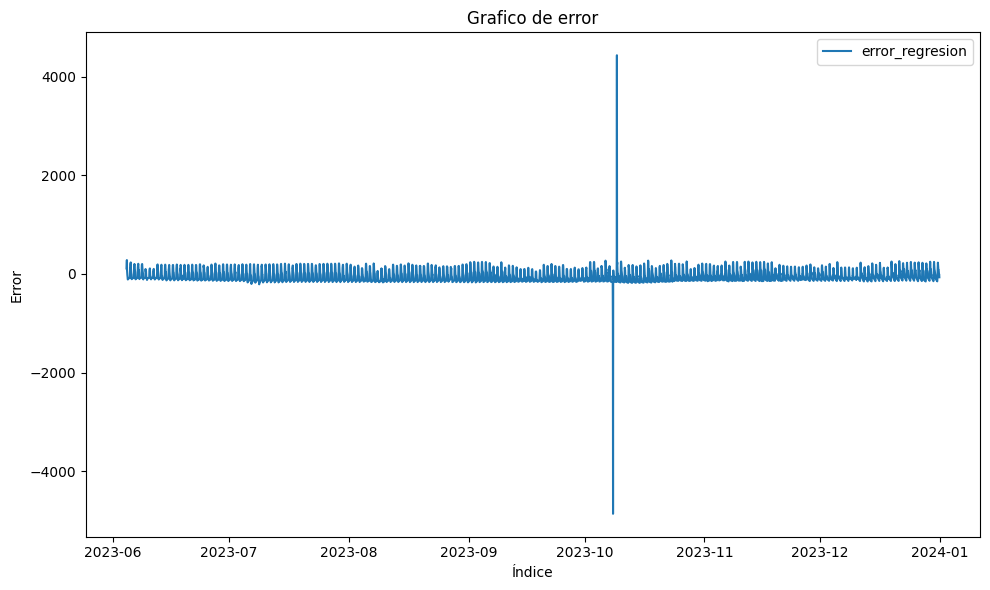

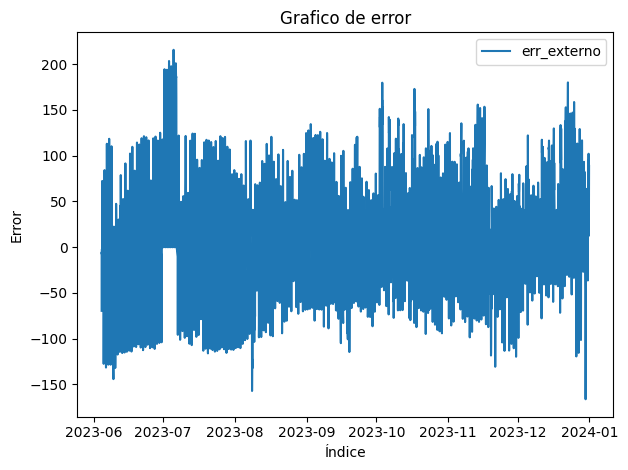

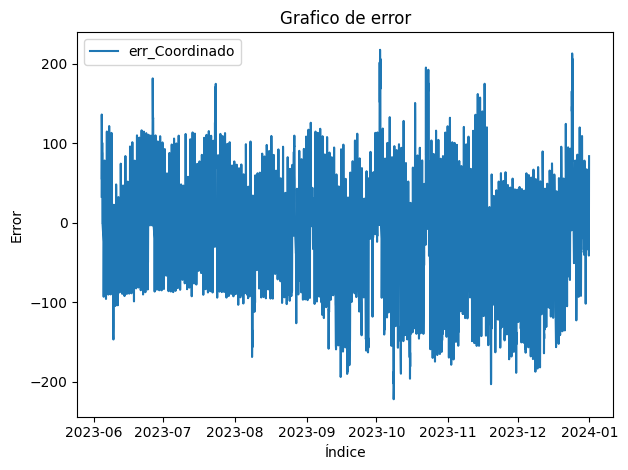

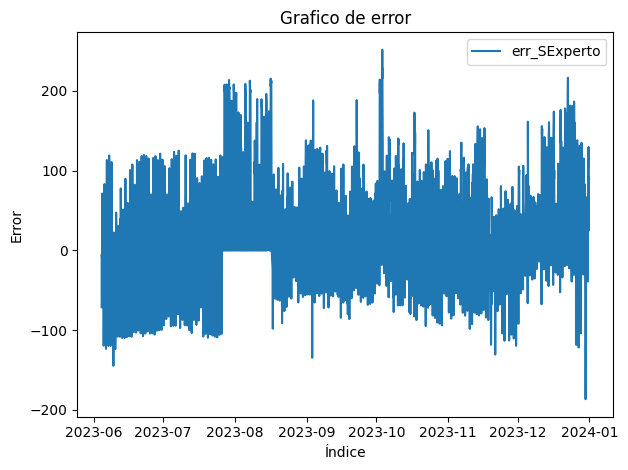

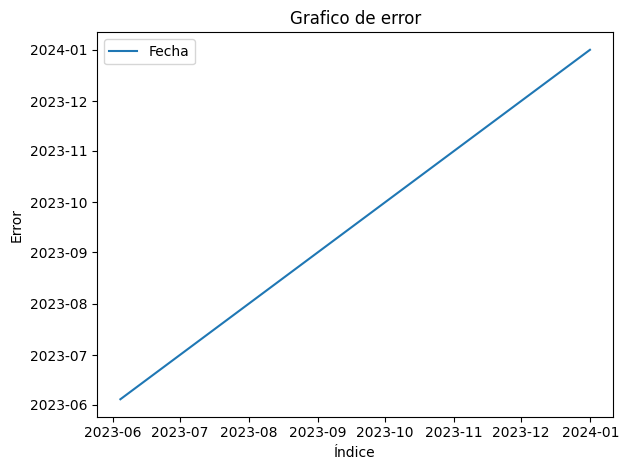

In [311]:
plt.figure(figsize=(10,6))
for column in error.columns:
    plt.plot(error['Fecha'], error[column], label=column)
    plt.title('Grafico de error')
    plt.xlabel('Índice')  # Etiqueta del eje x
    plt.ylabel('Error')  # Etiqueta del eje y
    plt.legend()  # Agrega una leyenda
    plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot
    plt.show()  # Muestra el gráfico

In [312]:
datos_central['Día'] = datos_central['Fecha'].dt.date
datos_central


,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,Día
390,2023-01-01 07:00:00,PFV FINIS TERRAE,20.3,36.09,28.198,248.21,0.000000,7,2023-01-01
407,2023-01-01 08:00:00,PFV FINIS TERRAE,83.3,135.79,108.934,248.21,42.204278,8,2023-01-01
472,2023-01-01 09:00:00,PFV FINIS TERRAE,105.4,212.18,137.310,248.21,59.850750,9,2023-01-01
546,2023-01-01 10:00:00,PFV FINIS TERRAE,110.1,244.09,137.310,248.21,57.510000,10,2023-01-01
586,2023-01-01 11:00:00,PFV FINIS TERRAE,114.9,260.37,137.310,248.21,77.441500,11,2023-01-01
...,...,...,...,...,...,...,...,...,...
509420,2023-12-31 16:00:00,PFV FINIS TERRAE,151.7,250.89,126.558,248.21,245.543000,16,2023-12-31
509463,2023-12-31 17:00:00,PFV FINIS TERRAE,152.3,241.25,131.036,248.21,204.208833,17,2023-12-31
509508,2023-12-31 18:00:00,PFV FINIS TERRAE,143.2,196.79,130.640,248.21,155.650000,18,2023-12-31
509630,2023-12-31 19:00:00,PFV FINIS TERRAE,68.3,86.38,64.141,248.21,155.590000,19,2023-12-31


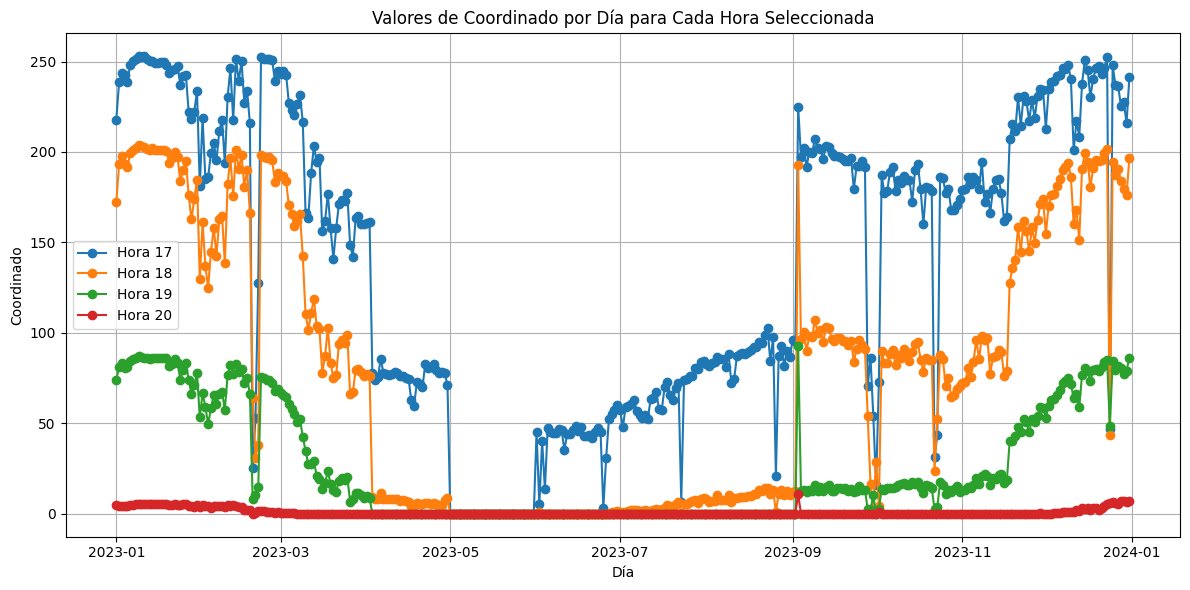

In [313]:
# Filtrar por las horas de interés
# Definir la fecha central y la ventana de tiempo
fecha_central = pd.to_datetime('2023-09-03')
ventana = pd.Timedelta(days=2)
horas_de_interés = [17, 18, 19, 20, 21]
datos_filtrados = datos_central[datos_central['Hora'].isin(horas_de_interés)]

# Pivotear el DataFrame
datos_pivoteados = datos_filtrados.pivot_table(index='Día', columns='Hora', values='Coordinado', aggfunc='mean')

# Graficar una línea por hora con puntos para cada día
plt.figure(figsize=(12, 6))

# Dibujar una línea por cada hora de interés
for hora in horas_de_interés:
    # Verificar si la hora está en las columnas después del pivot
    if hora in datos_pivoteados.columns:
        plt.plot(datos_pivoteados.index, datos_pivoteados[hora], '-o', label=f'Hora {hora}')

plt.title('Valores de Coordinado por Día para Cada Hora Seleccionada')
plt.xlabel('Día')
plt.ylabel('Coordinado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

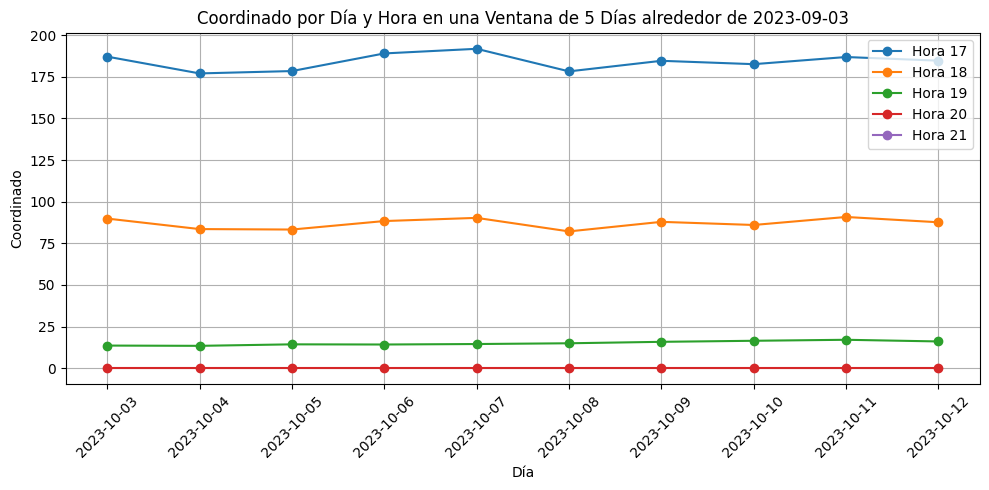

In [314]:
##Este es el cambio de hora

# Definimos la fecha central y el rango de fechas de la ventana
fecha_central = pd.to_datetime('2023-10-08')
ventana = pd.Timedelta(days=5)

# Seleccionamos la ventana de 5 días alrededor de la fecha central (2 días antes y 2 días después)
inicio_ventana = fecha_central - ventana
fin_ventana = fecha_central + ventana

# Filtramos el DataFrame para esta ventana de tiempo
datos_ventana = datos_central[(datos_central['Fecha'] >= inicio_ventana) & (datos_central['Fecha'] <= fin_ventana)]

# Filtramos las horas que nos interesan
horas_interes = [17, 18, 19, 20, 21]
datos_ventana = datos_ventana[datos_ventana['Fecha'].dt.hour.isin(horas_interes)]

# Creamos un gráfico de líneas donde cada línea representa una hora
plt.figure(figsize=(10, 5))

for hora in horas_interes:
    # Filtramos por hora
    df_hora = datos_ventana[datos_ventana['Fecha'].dt.hour == hora]
    # Agrupamos por fecha para asegurarnos de que no haya múltiples entradas por día
    df_hora = df_hora.groupby(df_hora['Fecha'].dt.date)['Coordinado'].mean().reset_index()
    # Graficamos
    plt.plot(df_hora['Fecha'], df_hora['Coordinado'], marker='o', label=f'Hora {hora}')


plt.title('Coordinado por Día y Hora en una Ventana de 5 Días alrededor de 2023-09-03')
plt.xlabel('Día')
plt.ylabel('Coordinado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje X para mejorar la legibilidad
plt.tight_layout()  # Ajustar el layout para evitar que se corten etiquetas o títulos
plt.show()

In [315]:
params = parametros_df.iloc[122:127]
ruta_archivo_excel = 'datos_central.xlsx'

# Usar el método to_excel para exportar el DataFrame a Excel, especificando el engine como 'openpyxl'
datos_central.to_excel(ruta_archivo_excel, engine='openpyxl', index=False)

In [299]:
 params = parametros_df[['h_19','Coordinado-h_19','Externo-h_19']].iloc[122:127]
 params

,h_19,Coordinado-h_19,Externo-h_19
122,0.602269,51.486048,2.998487e-13
123,0.637899,50.751801,-7.904683e-14
124,0.672437,50.047108,-2.845958e-14
125,0.708571,49.302696,3.209832e-13
126,0.712966,49.309997,-1.092017e+03


# ventana movil para 2 de septiembre

In [132]:
Y = datos_central['Generacion_Potencial']
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()
horas_relevantes

# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()


365


In [133]:
# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones

# Definir el conjunto de entrenamiento para la ventana actual
inicio = 125 * filas_por_dia
fin = inicio + num_dias_entrenamiento * filas_por_dia
X_train = X.iloc[inicio:fin]
Y_train = Y.iloc[inicio:fin]

# Ajustar el modelo
modelo = sm.OLS(Y_train, X_train).fit()

# Extraer y almacenar los parámetros estimados para la fecha actual
parametros_actuales = modelo.params
parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

# Realizar predicciones para el siguiente día
X_test = X.iloc[fin:fin + filas_por_dia]
predicciones = modelo.predict(X_test)

# Almacenar las predicciones
predicciones_df = pd.concat([predicciones_df, predicciones])

# Almacenar las variables utilizadas para la predicción del nuevo día
variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
#del X, X_train, X_test

          const   Externo  Coordinado           h_5           h_6      h_7  \
0 -1.912498e-12  0.245099    3.840161  9.570465e-13  3.717315e-12 -0.06792   

         h_8         h_9        h_10        h_11  ...  Coordinado-h_12  \
0  20.742766  132.000654  159.162162  171.479648  ...        -3.757942   

   Coordinado-h_13  Coordinado-h_14  Coordinado-h_15  Coordinado-h_16  \
0        -3.793295        -3.779754        -3.745963        -3.714625   

   Coordinado-h_17  Coordinado-h_18  Coordinado-h_19  Coordinado-h_20  \
0        -3.567616        -0.451384        49.302696              0.0   

   Coordinado-h_21  
0              0.0  

[1 rows x 54 columns]
               0
0  -1.912498e-12
1  -9.554518e-13
2   1.804817e-12
3  -6.692596e-02
4   1.751321e+01
5   1.300290e+02
6   1.705432e+02
7   1.800818e+02
8   1.819363e+02
9   1.795554e+02
10  1.770338e+02
11  1.724831e+02
12  1.718731e+02
13  1.705179e+02
14  1.061350e+03
15  4.933371e+03
16  4.224177e+01
17 -3.974144e-13
    const  E